In [948]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yfinance as yf
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import optuna

In [949]:
# Define additional metrics
def mean_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

def mean_absolute_percentage_error(y_true, y_pred): 
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

In [950]:
#Ex. AMZN','1997-05-15','2023-06-07'
def get_data(symbol, startdate, enddate):
    data = yf.download(symbol, startdate, enddate)
    data.to_csv(symbol + '.csv')
    return data

In [951]:
get_data('SPY', '1993-01-22', '2023-06-07')
data = pd.read_csv('SPY.csv')
data

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.122356,1003200
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.301022,480500
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.354626,201300
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.622629,529400
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.729856,531500
...,...,...,...,...,...,...,...
7638,2023-05-31,418.279999,419.220001,416.220001,417.850006,417.850006,110811800
7639,2023-06-01,418.089996,422.920013,416.790009,421.820007,421.820007,88865000
7640,2023-06-02,424.500000,428.739990,423.950012,427.920013,427.920013,91366700
7641,2023-06-05,428.279999,429.619995,426.369995,427.100006,427.100006,65460200


In [952]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1993-01-29,43.937500
1,1993-02-01,44.250000
2,1993-02-02,44.343750
3,1993-02-03,44.812500
4,1993-02-04,45.000000
...,...,...
7638,2023-05-31,417.850006
7639,2023-06-01,421.820007
7640,2023-06-02,427.920013
7641,2023-06-05,427.100006


In [953]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

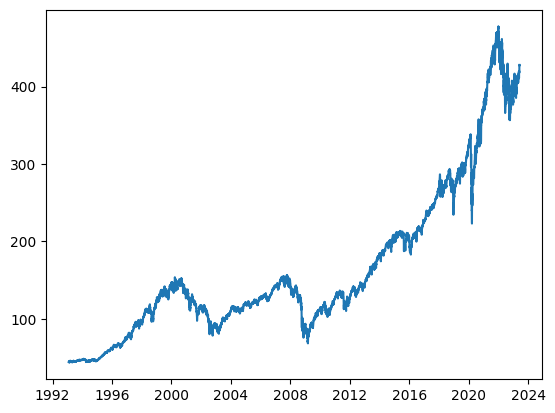

In [954]:
data = data.copy()
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [955]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1993-02-09,44.656250,44.968750,44.968750,45.000000,44.812500,44.343750,44.250000,43.937500
1993-02-10,44.718750,44.656250,44.968750,44.968750,45.000000,44.812500,44.343750,44.250000
1993-02-11,44.937500,44.718750,44.656250,44.968750,44.968750,45.000000,44.812500,44.343750
1993-02-12,44.593750,44.937500,44.718750,44.656250,44.968750,44.968750,45.000000,44.812500
1993-02-16,43.468750,44.593750,44.937500,44.718750,44.656250,44.968750,44.968750,45.000000
...,...,...,...,...,...,...,...,...
2023-05-31,417.850006,420.179993,420.019989,414.649994,411.089996,414.089996,418.790009,418.619995
2023-06-01,421.820007,417.850006,420.179993,420.019989,414.649994,411.089996,414.089996,418.790009
2023-06-02,427.920013,421.820007,417.850006,420.179993,420.019989,414.649994,411.089996,414.089996


In [956]:
shifted_df_as_np = shifted_df.to_numpy()

#shifted_df_as_np

In [957]:
#shifted_df_as_np.shape

In [958]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

#shifted_df_as_np

In [959]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

#X.shape, y.shape

In [960]:
X = dc(np.flip(X, axis=1))
#X

In [961]:
split_index = int(len(X) * 0.95)
#split_index

In [962]:
# Define the initial size of the training set
initial_train_size = int(len(X) * 0.7)

# Define the step size for each "walk" (how many data points to add to the training set each time)
step_size = int(len(X) * 0.05)

In [963]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7254, 7), (382, 7), (7254,), (382,))

In [964]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

#X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [965]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

#X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [966]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [967]:
train_dataset

In [968]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [969]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    #print(x_batch.shape, y_batch.shape)
    break

In [1080]:
def set_optimizer(trial, model):
    #Adam is proabaly best optimizer for this problem
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-2)
    #num_epochs = trial.suggest_int('num_epochs', 10, 200)
    num_epochs = 10

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    return optimizer, num_epochs

In [1081]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # just want last time step hidden states
        
        return out
    
def create_model(trial):
    hidden_size = trial.suggest_int('hidden_size', 4, 16)
    num_stacked_layers = trial.suggest_int('num_stacked_layers', 1, 3)
    
    model = LSTM(1, hidden_size, num_stacked_layers)
    model.to(device)
    
    return model

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [1082]:
def train_one_epoch(epoch, optimizer, loss_function):
    model.train(True)
    #print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss_across_batches = running_loss / 100
                
        if (batch_index + 1) % 100 == 99:  # print every 100 batches
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,avg_loss_across_batches))
            running_loss = 0.0
            
    return avg_loss_across_batches

In [1083]:
def validate_one_epoch(optimizer, loss_function):
    model.train(False)
    running_loss = 0.0
    running_mae = 0.0
    running_rmse = 0.0
    running_mape = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            running_mae += mean_absolute_error(y_batch, output).item()
            running_rmse += root_mean_squared_error(y_batch, output).item()
            running_mape += mean_absolute_percentage_error(y_batch, output).item()
            
        avg_loss_across_batches = running_loss / len(test_loader)
        avg_mae_across_batches = running_mae / len(test_loader)
        avg_rmse_across_batches = running_rmse / len(test_loader)
        avg_mape_across_batches = running_mape / len(test_loader)
        
    #perfect value for MAE and RMSE are 0, lower values indicate better model performance
    """
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('Val MAE: {0:.3f}'.format(avg_mae_across_batches))
    print('Val RMSE: {0:.3f}'.format(avg_rmse_across_batches))
    print('Val MAPE: {0:.3f}'.format(avg_mape_across_batches))
    print('***************************************************')
    print()
    """
    
    return avg_loss_across_batches

In [1084]:
def objective(trial):
    model = create_model(trial)
    optimizer, num_epochs = set_optimizer(trial, model)
    loss_function = nn.MSELoss()
    
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(epoch, optimizer, loss_function)
        val_loss = validate_one_epoch(optimizer, loss_function)

    return val_loss  # Optuna will try to minimize this value

In [1085]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # run 50 trials
print(study.best_trial.params)

[I 2023-06-08 15:05:16,255] A new study created in memory with name: no-name-a29f2dc6-f563-434c-be0e-b7d3ff565040
/var/tmp/ipykernel_40360/3170062733.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/var/tmp/ipykernel_40360/3170062733.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-2)


Batch 99, Loss: 0.282
Batch 199, Loss: 0.271
Batch 299, Loss: 0.287
Batch 399, Loss: 0.274
Batch 99, Loss: 0.274
Batch 199, Loss: 0.283
Batch 299, Loss: 0.277
Batch 399, Loss: 0.280
Batch 99, Loss: 0.263
Batch 199, Loss: 0.280
Batch 299, Loss: 0.284
Batch 399, Loss: 0.282
Batch 99, Loss: 0.282
Batch 199, Loss: 0.272
Batch 299, Loss: 0.280
Batch 399, Loss: 0.270
Batch 99, Loss: 0.271
Batch 199, Loss: 0.279
Batch 299, Loss: 0.277
Batch 399, Loss: 0.281
Batch 99, Loss: 0.283
Batch 199, Loss: 0.279
Batch 299, Loss: 0.279
Batch 399, Loss: 0.275
Batch 99, Loss: 0.280
Batch 199, Loss: 0.275
Batch 299, Loss: 0.279
Batch 399, Loss: 0.274
Batch 99, Loss: 0.280
Batch 199, Loss: 0.266
Batch 299, Loss: 0.279
Batch 399, Loss: 0.283
Batch 99, Loss: 0.275
Batch 199, Loss: 0.278
Batch 299, Loss: 0.280
Batch 399, Loss: 0.282
Batch 99, Loss: 0.268
Batch 199, Loss: 0.280
Batch 299, Loss: 0.276
Batch 399, Loss: 0.276


[I 2023-06-08 15:05:22,983] Trial 0 finished with value: 0.9212135995427767 and parameters: {'hidden_size': 15, 'num_stacked_layers': 3, 'optimizer': 'RMSprop', 'lr': 0.0008221353762000933, 'weight_decay': 7.383230594640487e-06}. Best is trial 0 with value: 0.9212135995427767.


Batch 99, Loss: 0.270
Batch 199, Loss: 0.276
Batch 299, Loss: 0.286
Batch 399, Loss: 0.281
Batch 99, Loss: 0.278
Batch 199, Loss: 0.281
Batch 299, Loss: 0.283
Batch 399, Loss: 0.274
Batch 99, Loss: 0.276
Batch 199, Loss: 0.286
Batch 299, Loss: 0.266
Batch 399, Loss: 0.279
Batch 99, Loss: 0.274
Batch 199, Loss: 0.276
Batch 299, Loss: 0.285
Batch 399, Loss: 0.281
Batch 99, Loss: 0.267
Batch 199, Loss: 0.276
Batch 299, Loss: 0.280
Batch 399, Loss: 0.287
Batch 99, Loss: 0.289
Batch 199, Loss: 0.273
Batch 299, Loss: 0.273
Batch 399, Loss: 0.278
Batch 99, Loss: 0.281
Batch 199, Loss: 0.272
Batch 299, Loss: 0.283
Batch 399, Loss: 0.275
Batch 99, Loss: 0.282
Batch 199, Loss: 0.281
Batch 299, Loss: 0.277
Batch 399, Loss: 0.270
Batch 99, Loss: 0.279
Batch 199, Loss: 0.280
Batch 299, Loss: 0.277
Batch 399, Loss: 0.275
Batch 99, Loss: 0.276
Batch 199, Loss: 0.278
Batch 299, Loss: 0.278
Batch 399, Loss: 0.285


[I 2023-06-08 15:05:29,590] Trial 1 finished with value: 0.9212135995427767 and parameters: {'hidden_size': 8, 'num_stacked_layers': 1, 'optimizer': 'SGD', 'lr': 0.00026610073078377455, 'weight_decay': 6.229297107828711e-08}. Best is trial 0 with value: 0.9212135995427767.


Batch 99, Loss: 0.277
Batch 199, Loss: 0.277
Batch 299, Loss: 0.285
Batch 399, Loss: 0.271
Batch 99, Loss: 0.280
Batch 199, Loss: 0.274
Batch 299, Loss: 0.279
Batch 399, Loss: 0.279
Batch 99, Loss: 0.281
Batch 199, Loss: 0.269
Batch 299, Loss: 0.285
Batch 399, Loss: 0.275
Batch 99, Loss: 0.271
Batch 199, Loss: 0.285
Batch 299, Loss: 0.277
Batch 399, Loss: 0.272
Batch 99, Loss: 0.273
Batch 199, Loss: 0.283
Batch 299, Loss: 0.272
Batch 399, Loss: 0.286
Batch 99, Loss: 0.267
Batch 199, Loss: 0.276
Batch 299, Loss: 0.283
Batch 399, Loss: 0.292
Batch 99, Loss: 0.278
Batch 199, Loss: 0.285
Batch 299, Loss: 0.271
Batch 399, Loss: 0.279
Batch 99, Loss: 0.269
Batch 199, Loss: 0.282
Batch 299, Loss: 0.278
Batch 399, Loss: 0.276
Batch 99, Loss: 0.271
Batch 199, Loss: 0.270
Batch 299, Loss: 0.282
Batch 399, Loss: 0.279
Batch 99, Loss: 0.274
Batch 199, Loss: 0.275
Batch 299, Loss: 0.269
Batch 399, Loss: 0.288


[I 2023-06-08 15:05:36,256] Trial 2 finished with value: 0.9212135995427767 and parameters: {'hidden_size': 13, 'num_stacked_layers': 1, 'optimizer': 'SGD', 'lr': 0.0018664859523335013, 'weight_decay': 2.506390560806581e-07}. Best is trial 0 with value: 0.9212135995427767.


Batch 99, Loss: 0.274
Batch 199, Loss: 0.287
Batch 299, Loss: 0.274
Batch 399, Loss: 0.274
Batch 99, Loss: 0.278
Batch 199, Loss: 0.266
Batch 299, Loss: 0.284
Batch 399, Loss: 0.277
Batch 99, Loss: 0.271
Batch 199, Loss: 0.275
Batch 299, Loss: 0.287
Batch 399, Loss: 0.277
Batch 99, Loss: 0.275
Batch 199, Loss: 0.276
Batch 299, Loss: 0.277
Batch 399, Loss: 0.283
Batch 99, Loss: 0.283
Batch 199, Loss: 0.283
Batch 299, Loss: 0.278
Batch 399, Loss: 0.265
Batch 99, Loss: 0.278
Batch 199, Loss: 0.277
Batch 299, Loss: 0.277
Batch 399, Loss: 0.274
Batch 99, Loss: 0.278
Batch 199, Loss: 0.282
Batch 299, Loss: 0.277
Batch 399, Loss: 0.273
Batch 99, Loss: 0.274
Batch 199, Loss: 0.278
Batch 299, Loss: 0.288
Batch 399, Loss: 0.272
Batch 99, Loss: 0.278
Batch 199, Loss: 0.275
Batch 299, Loss: 0.277
Batch 399, Loss: 0.282
Batch 99, Loss: 0.273
Batch 199, Loss: 0.279
Batch 299, Loss: 0.283
Batch 399, Loss: 0.277


[I 2023-06-08 15:05:42,850] Trial 3 finished with value: 0.9212135995427767 and parameters: {'hidden_size': 5, 'num_stacked_layers': 1, 'optimizer': 'RMSprop', 'lr': 0.003916202187864905, 'weight_decay': 0.0029414527550321186}. Best is trial 0 with value: 0.9212135995427767.


Batch 99, Loss: 0.273
Batch 199, Loss: 0.285
Batch 299, Loss: 0.277
Batch 399, Loss: 0.277
Batch 99, Loss: 0.274
Batch 199, Loss: 0.280
Batch 299, Loss: 0.285
Batch 399, Loss: 0.267
Batch 99, Loss: 0.274
Batch 199, Loss: 0.292
Batch 299, Loss: 0.274
Batch 399, Loss: 0.272
Batch 99, Loss: 0.280
Batch 199, Loss: 0.266
Batch 299, Loss: 0.282
Batch 399, Loss: 0.280
Batch 99, Loss: 0.279
Batch 199, Loss: 0.274
Batch 299, Loss: 0.276
Batch 399, Loss: 0.274
Batch 99, Loss: 0.283
Batch 199, Loss: 0.277
Batch 299, Loss: 0.282
Batch 399, Loss: 0.272
Batch 99, Loss: 0.283
Batch 199, Loss: 0.275
Batch 299, Loss: 0.268
Batch 399, Loss: 0.285
Batch 99, Loss: 0.280
Batch 199, Loss: 0.274
Batch 299, Loss: 0.284
Batch 399, Loss: 0.273
Batch 99, Loss: 0.277
Batch 199, Loss: 0.271
Batch 299, Loss: 0.275
Batch 399, Loss: 0.282
Batch 99, Loss: 0.274
Batch 199, Loss: 0.276
Batch 299, Loss: 0.280
Batch 399, Loss: 0.277


[I 2023-06-08 15:05:49,564] Trial 4 finished with value: 0.9212135995427767 and parameters: {'hidden_size': 10, 'num_stacked_layers': 1, 'optimizer': 'Adam', 'lr': 0.0001918087244246579, 'weight_decay': 4.752740704837404e-08}. Best is trial 0 with value: 0.9212135995427767.


Batch 99, Loss: 0.273
Batch 199, Loss: 0.275
Batch 299, Loss: 0.284
Batch 399, Loss: 0.280
Batch 99, Loss: 0.284
Batch 199, Loss: 0.277
Batch 299, Loss: 0.277
Batch 399, Loss: 0.276
Batch 99, Loss: 0.274
Batch 199, Loss: 0.278
Batch 299, Loss: 0.273
Batch 399, Loss: 0.282
Batch 99, Loss: 0.269
Batch 199, Loss: 0.273
Batch 299, Loss: 0.287
Batch 399, Loss: 0.284
Batch 99, Loss: 0.282
Batch 199, Loss: 0.267
Batch 299, Loss: 0.282
Batch 399, Loss: 0.280
Batch 99, Loss: 0.274
Batch 199, Loss: 0.277
Batch 299, Loss: 0.285
Batch 399, Loss: 0.274
Batch 99, Loss: 0.285
Batch 199, Loss: 0.280
Batch 299, Loss: 0.269
Batch 399, Loss: 0.277
Batch 99, Loss: 0.283
Batch 199, Loss: 0.277
Batch 299, Loss: 0.276
Batch 399, Loss: 0.269
Batch 99, Loss: 0.274
Batch 199, Loss: 0.278
Batch 299, Loss: 0.268
Batch 399, Loss: 0.278
Batch 99, Loss: 0.267
Batch 199, Loss: 0.286
Batch 299, Loss: 0.289
Batch 399, Loss: 0.273


[I 2023-06-08 15:05:56,393] Trial 5 finished with value: 0.9212135995427767 and parameters: {'hidden_size': 6, 'num_stacked_layers': 3, 'optimizer': 'Adam', 'lr': 0.00041953450860665657, 'weight_decay': 0.0008480566693239792}. Best is trial 0 with value: 0.9212135995427767.


Batch 99, Loss: 0.291
Batch 199, Loss: 0.274
Batch 299, Loss: 0.265
Batch 399, Loss: 0.275
Batch 99, Loss: 0.282
Batch 199, Loss: 0.286
Batch 299, Loss: 0.276
Batch 399, Loss: 0.274
Batch 99, Loss: 0.276
Batch 199, Loss: 0.272
Batch 299, Loss: 0.275
Batch 399, Loss: 0.286
Batch 99, Loss: 0.276
Batch 199, Loss: 0.277
Batch 299, Loss: 0.282
Batch 399, Loss: 0.270
Batch 99, Loss: 0.277
Batch 199, Loss: 0.277
Batch 299, Loss: 0.277
Batch 399, Loss: 0.276
Batch 99, Loss: 0.276
Batch 199, Loss: 0.273
Batch 299, Loss: 0.276
Batch 399, Loss: 0.282
Batch 99, Loss: 0.285
Batch 199, Loss: 0.280
Batch 299, Loss: 0.274
Batch 399, Loss: 0.276
Batch 99, Loss: 0.274
Batch 199, Loss: 0.273
Batch 299, Loss: 0.278
Batch 399, Loss: 0.281
Batch 99, Loss: 0.283
Batch 199, Loss: 0.270
Batch 299, Loss: 0.280
Batch 399, Loss: 0.277
Batch 99, Loss: 0.271
Batch 199, Loss: 0.279
Batch 299, Loss: 0.274


[I 2023-06-08 15:06:04,289] Trial 6 finished with value: 0.9212135995427767 and parameters: {'hidden_size': 6, 'num_stacked_layers': 2, 'optimizer': 'RMSprop', 'lr': 0.000141103322596191, 'weight_decay': 6.344477702996492e-06}. Best is trial 0 with value: 0.9212135995427767.


Batch 399, Loss: 0.283
Batch 99, Loss: 0.272
Batch 199, Loss: 0.285
Batch 299, Loss: 0.278
Batch 399, Loss: 0.281
Batch 99, Loss: 0.275
Batch 199, Loss: 0.284
Batch 299, Loss: 0.289
Batch 399, Loss: 0.265
Batch 99, Loss: 0.271
Batch 199, Loss: 0.271
Batch 299, Loss: 0.282
Batch 399, Loss: 0.280
Batch 99, Loss: 0.281
Batch 199, Loss: 0.282
Batch 299, Loss: 0.273
Batch 399, Loss: 0.280
Batch 99, Loss: 0.274
Batch 199, Loss: 0.280
Batch 299, Loss: 0.278
Batch 399, Loss: 0.278
Batch 99, Loss: 0.277
Batch 199, Loss: 0.276
Batch 299, Loss: 0.277
Batch 399, Loss: 0.275
Batch 99, Loss: 0.275
Batch 199, Loss: 0.272
Batch 299, Loss: 0.275
Batch 399, Loss: 0.280
Batch 99, Loss: 0.266
Batch 199, Loss: 0.280
Batch 299, Loss: 0.279
Batch 399, Loss: 0.279
Batch 99, Loss: 0.277
Batch 199, Loss: 0.273
Batch 299, Loss: 0.285
Batch 399, Loss: 0.274
Batch 99, Loss: 0.278
Batch 199, Loss: 0.276
Batch 299, Loss: 0.284
Batch 399, Loss: 0.267


[I 2023-06-08 15:06:11,337] Trial 7 finished with value: 0.9212135995427767 and parameters: {'hidden_size': 8, 'num_stacked_layers': 1, 'optimizer': 'RMSprop', 'lr': 0.006433532312040222, 'weight_decay': 3.9044818684706705e-05}. Best is trial 0 with value: 0.9212135995427767.


Batch 99, Loss: 0.280
Batch 199, Loss: 0.275
Batch 299, Loss: 0.283
Batch 399, Loss: 0.274
Batch 99, Loss: 0.273
Batch 199, Loss: 0.282
Batch 299, Loss: 0.281
Batch 399, Loss: 0.270
Batch 99, Loss: 0.277
Batch 199, Loss: 0.279
Batch 299, Loss: 0.279
Batch 399, Loss: 0.276
Batch 99, Loss: 0.284
Batch 199, Loss: 0.274
Batch 299, Loss: 0.262
Batch 399, Loss: 0.289
Batch 99, Loss: 0.278
Batch 199, Loss: 0.274
Batch 299, Loss: 0.282
Batch 399, Loss: 0.280
Batch 99, Loss: 0.276
Batch 199, Loss: 0.283
Batch 299, Loss: 0.277
Batch 399, Loss: 0.276
Batch 99, Loss: 0.271
Batch 199, Loss: 0.284
Batch 299, Loss: 0.279
Batch 399, Loss: 0.286
Batch 99, Loss: 0.281
Batch 199, Loss: 0.274
Batch 299, Loss: 0.276
Batch 399, Loss: 0.284
Batch 99, Loss: 0.279
Batch 199, Loss: 0.277
Batch 299, Loss: 0.278
Batch 399, Loss: 0.279
Batch 99, Loss: 0.279
Batch 199, Loss: 0.274
Batch 299, Loss: 0.275
Batch 399, Loss: 0.285


[I 2023-06-08 15:06:18,048] Trial 8 finished with value: 0.9212135995427767 and parameters: {'hidden_size': 10, 'num_stacked_layers': 2, 'optimizer': 'SGD', 'lr': 0.00010340306976043382, 'weight_decay': 0.0010745698265111803}. Best is trial 0 with value: 0.9212135995427767.


Batch 99, Loss: 0.268
Batch 199, Loss: 0.274
Batch 299, Loss: 0.283
Batch 399, Loss: 0.292
Batch 99, Loss: 0.278
Batch 199, Loss: 0.278
Batch 299, Loss: 0.285
Batch 399, Loss: 0.270
Batch 99, Loss: 0.284
Batch 199, Loss: 0.274
Batch 299, Loss: 0.275
Batch 399, Loss: 0.275
Batch 99, Loss: 0.279
Batch 199, Loss: 0.280
Batch 299, Loss: 0.274
Batch 399, Loss: 0.280
Batch 99, Loss: 0.276
Batch 199, Loss: 0.267
Batch 299, Loss: 0.281
Batch 399, Loss: 0.285
Batch 99, Loss: 0.280
Batch 199, Loss: 0.277
Batch 299, Loss: 0.276
Batch 399, Loss: 0.281
Batch 99, Loss: 0.275
Batch 199, Loss: 0.275
Batch 299, Loss: 0.285
Batch 399, Loss: 0.274
Batch 99, Loss: 0.279
Batch 199, Loss: 0.276
Batch 299, Loss: 0.277
Batch 399, Loss: 0.273
Batch 99, Loss: 0.277
Batch 199, Loss: 0.283
Batch 299, Loss: 0.272
Batch 399, Loss: 0.277
Batch 99, Loss: 0.281
Batch 199, Loss: 0.280
Batch 299, Loss: 0.280
Batch 399, Loss: 0.271


[I 2023-06-08 15:06:24,673] Trial 9 finished with value: 0.9212135995427767 and parameters: {'hidden_size': 6, 'num_stacked_layers': 1, 'optimizer': 'RMSprop', 'lr': 0.009751632882645024, 'weight_decay': 0.0001790704703844254}. Best is trial 0 with value: 0.9212135995427767.


{'hidden_size': 15, 'num_stacked_layers': 3, 'optimizer': 'RMSprop', 'lr': 0.0008221353762000933, 'weight_decay': 7.383230594640487e-06}


In [1086]:
# Get the best hyperparameters
best_params = study.best_trial.params

# Define your model and optimizer using the best parameters
model = CustomLSTM(input_size=1, hidden_size=best_params["hidden_size"], num_layers=best_params["num_stacked_layers"], output_size=1)
model.to(device)

# Set your optimizer
if best_params["optimizer"] == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])
elif best_params["optimizer"] == "RMSprop":
    optimizer = optim.RMSprop(model.parameters(), lr=best_params["lr"])
elif best_params["optimizer"] == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=best_params["lr"])
else:
    raise ValueError("Unknown optimizer: " + best_params["optimizer"])

# Define loss function
loss_function = nn.MSELoss()

# Start Walk Forward Validation
for i in range(initial_train_size, len(X) - step_size, step_size):
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i+step_size]
    y_test = y[i:i+step_size]
    
    # Reshape to match the expected input of your model
    X_train = X_train.reshape((-1, lookback, 1))
    X_test = X_test.reshape((-1, lookback, 1))
    y_train = y_train.reshape((-1, 1))
    y_test = y_test.reshape((-1, 1))
    
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).float()
    X_test = torch.tensor(X_test).float()
    y_test = torch.tensor(y_test).float()

    # Create DataLoaders
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train the model
    for epoch in range(num_epochs):
        train_one_epoch(epoch, optimizer, loss_function)
        
    # Validate the model
    model.train(True)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


Batch 99, Loss: 0.064
Batch 199, Loss: 0.002
Batch 299, Loss: 0.001
Batch 99, Loss: 0.001
Batch 199, Loss: 0.001
Batch 299, Loss: 0.001
Val Loss: 0.004
***************************************************

Batch 99, Loss: 0.001
Batch 199, Loss: 0.001
Batch 299, Loss: 0.001
Batch 99, Loss: 0.001
Batch 199, Loss: 0.001
Batch 299, Loss: 0.001
Val Loss: 0.001
***************************************************

Batch 99, Loss: 0.001
Batch 199, Loss: 0.001
Batch 299, Loss: 0.001
Batch 99, Loss: 0.000
Batch 199, Loss: 0.000
Batch 299, Loss: 0.001
Val Loss: 0.007
***************************************************

Batch 99, Loss: 0.001
Batch 199, Loss: 0.001
Batch 299, Loss: 0.001
Batch 399, Loss: 0.000
Batch 99, Loss: 0.000
Batch 199, Loss: 0.000
Batch 299, Loss: 0.000
Batch 399, Loss: 0.000
Val Loss: 0.004
***************************************************

Batch 99, Loss: 0.001
Batch 199, Loss: 0.001
Batch 299, Loss: 0.001
Batch 399, Loss: 0.001
Batch 99, Loss: 0.001
Batch 199, Loss: 0.00

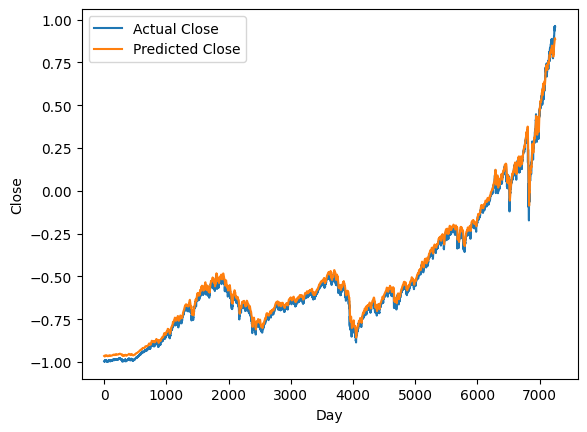

In [1087]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [1088]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
#train_predictions

In [1089]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
#new_y_train

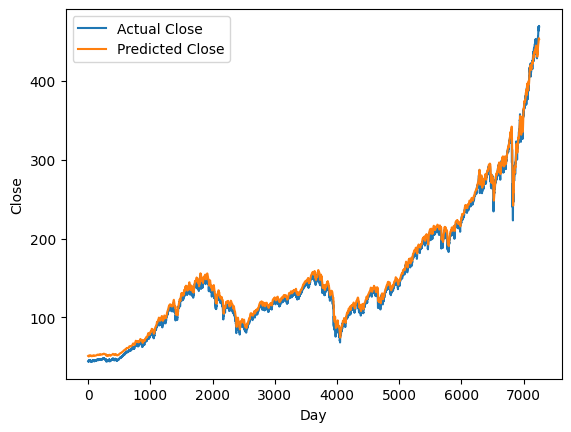

In [1090]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [1091]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
#test_predictions

In [1092]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
#new_y_test

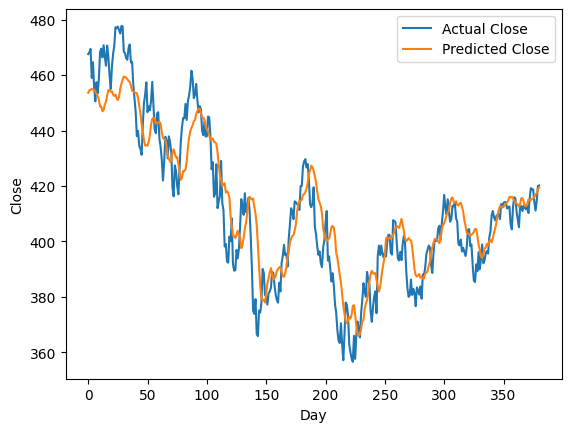

In [1093]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [1096]:
# Step 1: Prepare the most recent lookback days data
recent_data = np.array(data['Close'][-lookback:])

# Create a dummy 2D array with the same shape as the training data
dummy = np.zeros((1, lookback + 1))

# Put recent_data in the first lookback positions
dummy[0, :lookback] = recent_data

# Scale the data like you did in training
recent_data_scaled = scaler.transform(dummy)[:, :lookback]

# Convert to tensor and add an extra dimension for batch (PyTorch LSTM expects input in this shape: (batch, seq_len, input_size))
recent_data_scaled = torch.tensor(recent_data_scaled).float().to(device)
recent_data_scaled = recent_data_scaled.unsqueeze(0)

# Check the shapea of recent_data_scaled
#print("Shape of recent_data_scaled:", recent_data_scaled.shape)

# Reshape to (batch_size, sequence_length, number_of_features)
recent_data_scaled = recent_data_scaled.view(recent_data_scaled.shape[0], -1, 1)

# Step 2: Generate the prediction using the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predicted_price_scaled = model(recent_data_scaled)

# Prepare dummy data to inverse transform the predicted price
dummy[0, :lookback] = 0
dummy[0, lookback] = predicted_price_scaled.item()

# Step 3: Reverse the scaling of the predicted price
predicted_price = scaler.inverse_transform(dummy)[0, lookback]

print("Forecasted Closing Price for Today:")
print(predicted_price)

Forecasted Closing Price for Today:
422.37884878080143


In [1097]:
# Define how many steps to forecast
forecast_horizon = 5

model.eval()  # Set the model to evaluation mode

# Create a dummy 2D array with the same shape as the training data
dummy = np.zeros((1, lookback + 1))

# Step 1: Prepare the most recent lookback days data
recent_data = np.array(data['Close'][-lookback:])

# Start off the predictions with the most recent data
predictions = recent_data.tolist()

for _ in range(forecast_horizon):
    # Use the most recent lookback data for predictions
    dummy[0, :lookback] = predictions[-lookback:]

    # Scale the data like you did in training
    recent_data_scaled = scaler.transform(dummy)[:, :lookback]

    # Convert to tensor and add an extra dimension for batch (PyTorch LSTM expects input in this shape: (batch, seq_len, input_size))
    recent_data_scaled = torch.tensor(recent_data_scaled).float().to(device)
    recent_data_scaled = recent_data_scaled.unsqueeze(0)

    # Reshape to (batch_size, sequence_length, number_of_features)
    recent_data_scaled = recent_data_scaled.view(recent_data_scaled.shape[0], -1, 1)

    # Step 2: Generate the prediction using the model
    with torch.no_grad():
        predicted_price_scaled = model(recent_data_scaled)

    # Prepare dummy data to inverse transform the predicted price
    dummy[0, :lookback] = 0
    dummy[0, lookback] = predicted_price_scaled.item()

    # Step 3: Reverse the scaling of the predicted price
    predicted_price = scaler.inverse_transform(dummy)[0, lookback]

    # Append the predicted price to the list of predictions
    predictions.append(predicted_price)

# The forecasted prices are the last 'forecast_horizon' predictions
forecasted_prices = predictions[-forecast_horizon:]

print("Forecasted Closing Prices for Today and Next 4 Days:")
print(forecasted_prices)


Forecasted Closing Prices for Today and Next 4 Days:
[422.37884878080143, 423.0043188826966, 423.7475467651365, 425.4895024847264, 426.5147640051163]
